('Datasets:', 'full:', (1309, 12), 'titanic:', (891, 12))
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


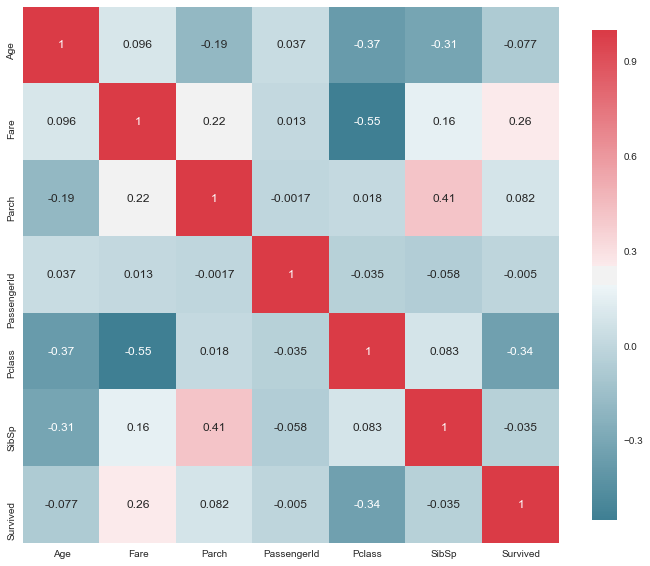

In [119]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder

# Visualisation
import matplotlib.pylab as pylab
import seaborn as sns

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
# Configure visualisations
#%matplotlib inline
#mpl.style.use( 'ggplot' )
#sns.set_style( 'white' )
#Visualization
#import seaborn as sns
#import matplotlib as mpl
#import matplotlib.pyplot as plt
#import matplotlib.pylab as pylab
#pylab.rcParams['figure.figsize'] = 8,6 # Big graphs unless specified
sns.set(color_codes=True) # Set style and color of graphs

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()
def plot_correlation_map( df ):
    corr = titanic.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
train = pd.read_csv("/Users/houzhuo/Downloads/train.csv")
test    = pd.read_csv("/Users/houzhuo/Downloads/test.csv")
full = train.append(test,ignore_index=True)
titanic = full[:891]
print ('Datasets:' , 'full:' , full.shape , 'titanic:' , titanic.shape)
full.info()
plot_correlation_map(full)

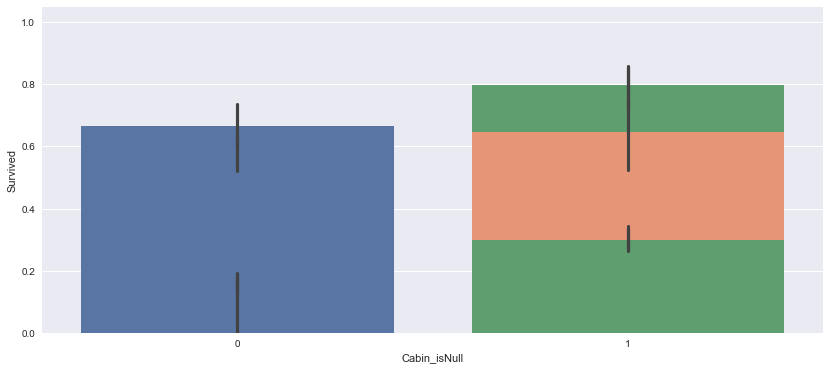

In [120]:
#Title
title = pd.DataFrame()
full['Title'] = full['Name'].map(lambda name:name.split(',')[1].split( '.' )[0].strip())
plt.figure(figsize=(14,6))
sns.barplot('Title', 'Survived', data=full)
#plt.show()
full['Title'] = full['Title'].replace(['Don','Dona', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col','Sir','Dr'],'Mr')
full['Title'] = full['Title'].replace(['Mlle','Ms'], 'Miss')
full['Title'] = full['Title'].replace(['the Countess','Mme','Lady','Dr'], 'Mrs')
title = pd.get_dummies(full['Title'],prefix='Title')
full = pd.concat([full,title],axis=1)
sns.barplot('Title', 'Survived', data=full)

#Age & isChild
group = full.groupby(['Sex','Title', 'Pclass'])['Age']
full['Age'] = group.transform(lambda x: x.fillna(x.median()))
full['IsChild'] = np.where(full['Age']<=12,1,0)
full['IsOld'] = np.where(full['Age']>=63,1,0)

#Dead_female_family & Survive_male_family
full['Surname'] = full['Name'].apply(lambda x:x.split(',')[0])
dead_female_surname = list(set(full[(full.Sex=='female') & (full.Age>=12)
                              & (full.Survived==0) & ((full.Parch>0) | (full.SibSp > 0))]['Surname'].values))
survive_male_surname = list(set(full[(full.Sex=='male') & (full.Age>=12)
                              & (full.Survived==1) & ((full.Parch>0) | (full.SibSp > 0))]['Surname'].values))
full['Dead_female_family'] = np.where(full['Surname'].isin(dead_female_surname),0,1)
full['Survive_male_family'] = np.where(full['Surname'].isin(survive_male_surname),0,1)
#full = full.drop(['Name','Surname'],axis=1)

#FamilySize
full['FamilySize'] = np.where(full['SibSp']+full['Parch']==0, 'Alone',
                                    np.where(full['SibSp']+full['Parch']<=3, 'Small', 'Big'))
sns.barplot('FamilySize', 'Survived', data=full)
df = pd.get_dummies(full['FamilySize'],prefix='FamilySize')
full = pd.concat([full,df],axis=1).drop(['SibSp','Parch','FamilySize'],axis=1)

#Ticket_letter
full['Ticket_Lett'] = full['Ticket'].apply(lambda x: str(x)[0])
full['Ticket_Lett'] = full['Ticket_Lett'].apply(lambda x: str(x))
sns.barplot('Ticket_Lett', 'Survived', data=full)
full['High_Survival_Ticket'] = np.where(full['Ticket_Lett'].isin(['1', '2', 'P']),1,0)
full['Low_Survival_Ticket'] = np.where(full['Ticket_Lett'].isin(['A','W','3','7']),1,0)
#full = full.drop(['Ticket','Ticket_Lett'],axis=1)

#Embarked
#full = full.drop('Embarked',axis=1)
full['Embarked_isC'] = np.where(full['Embarked']=='C',1,0)
#sns.barplot('Embarked_isC','Survived',data=full)

#Cabin
full[ 'Cabin' ] = full.Cabin.fillna( 'U' )
full['Cabin_isNull'] = np.where(full['Cabin']=='U',1,0)
sns.barplot('Cabin_isNull','Survived',data=full)

#Sex
full['Sex'] = pd.Series( np.where( full.Sex == 'male' , 1 , 0 ) , name = 'Sex' )
#PClass
df = pd.get_dummies(full['Pclass'],prefix='Pclass')
full = pd.concat([full,df],axis=1)

#pclass3male = list(set(full[(full.Sex==1) & (full['Pclass']==1)]['PassengerId'].values))
#full['Pclass3male'] = np.where(full['PassengerId'].isin(pclass3male),1,0)
#sns.barplot(x="Pclass3male", y="Survived", hue = 'Sex' ,data=full);


#Fare
full['Fare'].fillna(full['Fare'].dropna().median(),inplace=True)
full['Low_Fare'] = np.where(full['Fare']<=8.66,1,0)
full['High_Fare'] = np.where(full['Fare']>=26,1,0)

In [121]:
#Ticket_count
full["TicketCount"] = full.Ticket.apply(lambda x: 1 if x in full.Ticket.unique() and
                                        full.Ticket.value_counts()[x] > 1  else 0)
#np.where(full['TicketCount']=='CA. 2343')
full["TicketCount"]

0       0
1       1
2       0
3       1
4       0
5       0
6       1
7       1
8       1
9       1
10      1
11      0
12      0
13      1
14      0
15      0
16      1
17      0
18      1
19      0
20      1
21      0
22      0
23      0
24      1
25      1
26      0
27      1
28      0
29      0
       ..
1279    0
1280    1
1281    1
1282    1
1283    1
1284    0
1285    1
1286    1
1287    0
1288    1
1289    0
1290    0
1291    1
1292    1
1293    1
1294    1
1295    0
1296    0
1297    0
1298    1
1299    0
1300    1
1301    0
1302    1
1303    0
1304    0
1305    1
1306    0
1307    0
1308    1
Name: TicketCount, Length: 1309, dtype: int64

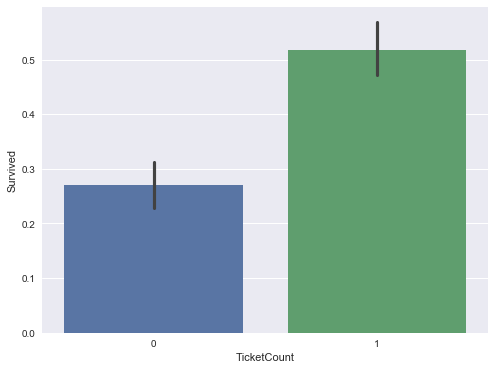

In [52]:

sns.barplot("TicketCount",y="Survived", data=full)

In [123]:
full_X = full
full_X = full_X.drop('PassengerId',axis=1)
full_X = full_X.drop('Survived',axis=1)
full_X = full_X.drop('Embarked',axis=1)
full_X = full_X.drop('Age',axis=1)
full_X = full_X.drop('Name',axis=1)
full_X = full_X.drop('Surname',axis=1)
full_X = full_X.drop('Title',axis=1)
full_X = full_X.drop('Fare',axis=1)
full_X = full_X.drop('Ticket',axis=1)
full_X = full_X.drop('Ticket_Lett',axis=1)
full_X = full_X.drop('Cabin',axis=1)
full_X = full_X.drop('Pclass',axis=1)

In [124]:
full_X.head()

,Sex,Title_Master,Title_Miss,Title_Mr,Title_Mrs,IsChild,IsOld,Dead_female_family,Survive_male_family,FamilySize_Alone,...,High_Survival_Ticket,Low_Survival_Ticket,Embarked_isC,Cabin_isNull,Pclass_1,Pclass_2,Pclass_3,Low_Fare,High_Fare,TicketCount
0,1,0,0,1,0,0,0,1,1,0,...,0,1,0,1,0,0,1,1,0,0
1,0,0,0,0,1,0,0,1,1,0,...,1,0,1,0,1,0,0,0,1,1
2,0,0,1,0,0,0,0,1,1,1,...,0,0,0,1,0,0,1,1,0,0
3,0,0,0,0,1,0,0,1,1,0,...,1,0,0,0,1,0,0,0,1,1
4,1,0,0,1,0,0,0,1,1,1,...,0,1,0,1,0,0,1,1,0,0


In [125]:
X_train= full_X[ 0:891 ]
y_train = titanic.Survived
X_test = full_X[ 891: ]
print (full_X.shape , X_train.shape , X_test.shape , y_train.shape )
X_train.info()

((1309, 22), (891, 22), (418, 22), (891,))
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 22 columns):
Sex                     891 non-null int64
Title_Master            891 non-null uint8
Title_Miss              891 non-null uint8
Title_Mr                891 non-null uint8
Title_Mrs               891 non-null uint8
IsChild                 891 non-null int64
IsOld                   891 non-null int64
Dead_female_family      891 non-null int64
Survive_male_family     891 non-null int64
FamilySize_Alone        891 non-null uint8
FamilySize_Big          891 non-null uint8
FamilySize_Small        891 non-null uint8
High_Survival_Ticket    891 non-null int64
Low_Survival_Ticket     891 non-null int64
Embarked_isC            891 non-null int64
Cabin_isNull            891 non-null int64
Pclass_1                891 non-null uint8
Pclass_2                891 non-null uint8
Pclass_3                891 non-null uint8
Low_Fare                891 non-nul

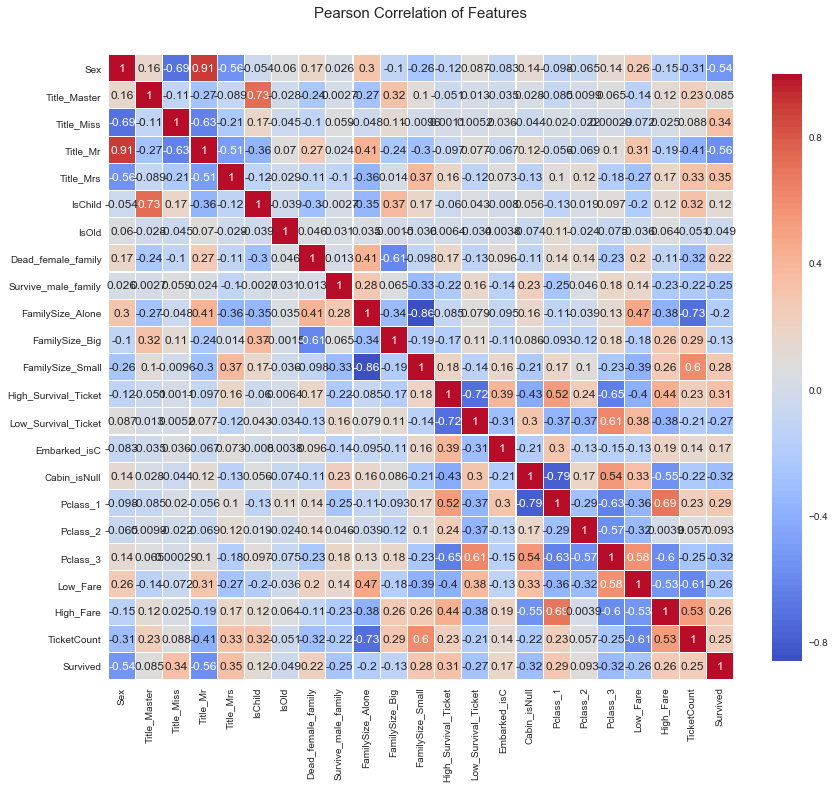

In [126]:

coef = pd.concat([X_train,y_train],axis=1)
correlation_heatmap(coef)

((1309, 22), (891, 22), (418, 22), (891,))
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 22 columns):
Sex                     891 non-null int64
Title_Master            891 non-null uint8
Title_Miss              891 non-null uint8
Title_Mr                891 non-null uint8
Title_Mrs               891 non-null uint8
IsChild                 891 non-null int64
IsOld                   891 non-null int64
Dead_female_family      891 non-null int64
Survive_male_family     891 non-null int64
FamilySize_Alone        891 non-null uint8
FamilySize_Big          891 non-null uint8
FamilySize_Small        891 non-null uint8
High_Survival_Ticket    891 non-null int64
Low_Survival_Ticket     891 non-null int64
Embarked_isC            891 non-null int64
Cabin_isNull            891 non-null int64
Pclass_1                891 non-null uint8
Pclass_2                891 non-null uint8
Pclass_3                891 non-null uint8
Low_Fare                891 non-nul

In [93]:
from sklearn import cross_validation, metrics
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], y_train)

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]

    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], y_train, cv=cv_folds, scoring='roc_auc')

    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(y_train, dtrain_predprob)

    if performCV:
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))

    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.9057
AUC Score (Train): 0.958180
CV Score : Mean - 0.9326427 | Std - 0.01621321 | Min - 0.905336 | Max - 0.9548748


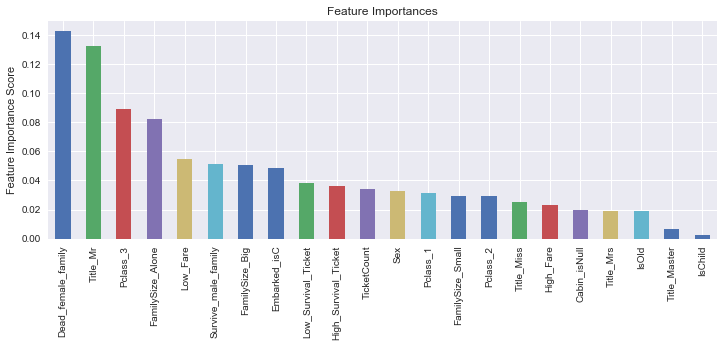

In [94]:
#Choose all predictors except target & IDcols
predictors = [x for x in X_train.columns]
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, X_train, predictors)

In [97]:
#Choose all predictors 
#search n_estimators First
from sklearn.grid_search import GridSearchCV 
predictors = [x for x in X_train.columns]
param_test1 = {'n_estimators':range(11,52,5)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                                               min_samples_split=5,
                                                               min_samples_leaf=5,
                                                               max_depth=8,
                                                               max_features='sqrt',
                                                               subsample=0.8,
                                                               random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.91988, std: 0.01965, params: {'n_estimators': 11},
  mean: 0.92222, std: 0.02222, params: {'n_estimators': 16},
  mean: 0.92501, std: 0.02226, params: {'n_estimators': 21},
  mean: 0.92795, std: 0.02301, params: {'n_estimators': 26},
  mean: 0.93282, std: 0.02056, params: {'n_estimators': 31},
  mean: 0.93402, std: 0.02118, params: {'n_estimators': 36},
  mean: 0.93334, std: 0.02369, params: {'n_estimators': 41},
  mean: 0.93284, std: 0.02371, params: {'n_estimators': 46},
  mean: 0.93265, std: 0.02526, params: {'n_estimators': 51}],
 {'n_estimators': 36},
 0.9340163549192386)

In [98]:
#use n_estimators above
param_test2 = {'max_depth':range(1,16,2),
               'min_samples_split':range(2,20,2)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                                               n_estimators=36,
                                                               max_features='sqrt',
                                                               subsample=0.8, 
                                                               random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.88860, std: 0.01636, params: {'min_samples_split': 2, 'max_depth': 1},
  mean: 0.88860, std: 0.01636, params: {'min_samples_split': 4, 'max_depth': 1},
  mean: 0.88860, std: 0.01636, params: {'min_samples_split': 6, 'max_depth': 1},
  mean: 0.88860, std: 0.01636, params: {'min_samples_split': 8, 'max_depth': 1},
  mean: 0.88860, std: 0.01636, params: {'min_samples_split': 10, 'max_depth': 1},
  mean: 0.88860, std: 0.01636, params: {'min_samples_split': 12, 'max_depth': 1},
  mean: 0.88860, std: 0.01636, params: {'min_samples_split': 14, 'max_depth': 1},
  mean: 0.88860, std: 0.01636, params: {'min_samples_split': 16, 'max_depth': 1},
  mean: 0.88860, std: 0.01636, params: {'min_samples_split': 18, 'max_depth': 1},
  mean: 0.92328, std: 0.01876, params: {'min_samples_split': 2, 'max_depth': 3},
  mean: 0.92382, std: 0.01901, params: {'min_samples_split': 4, 'max_depth': 3},
  mean: 0.92153, std: 0.01838, params: {'min_samples_split': 6, 'max_depth': 3},
  mean: 0.92031, std: 0

In [99]:
param_test3 = {'min_samples_leaf':range(1,20,1),
               'max_features':range(7,21,2),
              'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]
              }
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                                               n_estimators=36,
                                                               max_depth=5,
                                                               min_samples_split=18,
                                                               #max_features='sqrt',
                                                               #subsample=0.8, 
                                                               random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.93654, std: 0.01444, params: {'max_features': 7, 'subsample': 0.6, 'min_samples_leaf': 1},
  mean: 0.93706, std: 0.01598, params: {'max_features': 7, 'subsample': 0.7, 'min_samples_leaf': 1},
  mean: 0.93549, std: 0.01696, params: {'max_features': 7, 'subsample': 0.75, 'min_samples_leaf': 1},
  mean: 0.93704, std: 0.01515, params: {'max_features': 7, 'subsample': 0.8, 'min_samples_leaf': 1},
  mean: 0.93745, std: 0.01251, params: {'max_features': 7, 'subsample': 0.85, 'min_samples_leaf': 1},
  mean: 0.93807, std: 0.01577, params: {'max_features': 7, 'subsample': 0.9, 'min_samples_leaf': 1},
  mean: 0.93295, std: 0.01369, params: {'max_features': 7, 'subsample': 0.6, 'min_samples_leaf': 2},
  mean: 0.93564, std: 0.01849, params: {'max_features': 7, 'subsample': 0.7, 'min_samples_leaf': 2},
  mean: 0.93668, std: 0.01916, params: {'max_features': 7, 'subsample': 0.75, 'min_samples_leaf': 2},
  mean: 0.93544, std: 0.01426, params: {'max_features': 7, 'subsample': 0.8, 'min_sample


Model Report
Accuracy : 0.9035
AUC Score (Train): 0.959802
CV Score : Mean - 0.9403859 | Std - 0.01356228 | Min - 0.9144269 | Max - 0.9530303


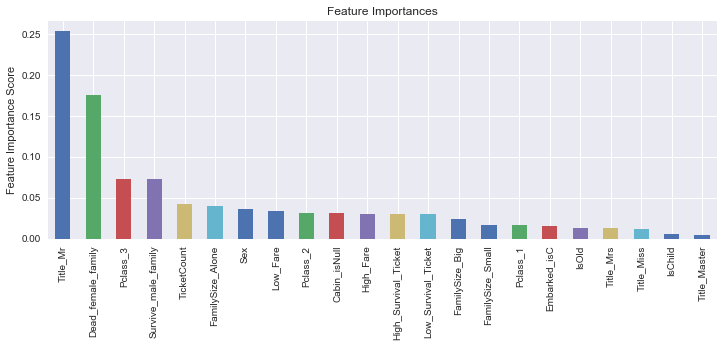

In [101]:
#decrease the learning rate to half, i.e. 0.05 with twice (102) the number of trees.
predictors = [x for x in X_train.columns]
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.1, 
                                         n_estimators=36,
                                         max_depth=5,
                                         min_samples_split=13,
                                         min_samples_leaf=1, 
                                         subsample=0.85, 
                                         random_state=10, 
                                         max_features=13)
modelfit(gbm_tuned_1, X_train, predictors)

In [103]:
from sklearn.cross_validation import cross_val_score

def compute_score(model, X, y, scoring='accuracy'):
    xval = cross_val_score(model, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)
parameters={'n_estimators':36,
            'max_depth':5,
            'min_samples_split':13,
            'min_samples_leaf':1, 
            'random_state':10,
            'max_features':13,
           'bootstrap': False}
model = RandomForestClassifier(**parameters)
model.fit(X_train, y_train)
compute_score(model,X_train, y_train, scoring='accuracy')

0.8776709730203025

In [104]:
y_test = model.predict( X_test )

passenger_id = full[891:].PassengerId
test = pd.DataFrame( { 'PassengerId': passenger_id , 'Survived': y_test.astype(np.int64) } )
#test.shape
#test.head()
test.to_csv( 'titanic_pred.csv' , index = False )

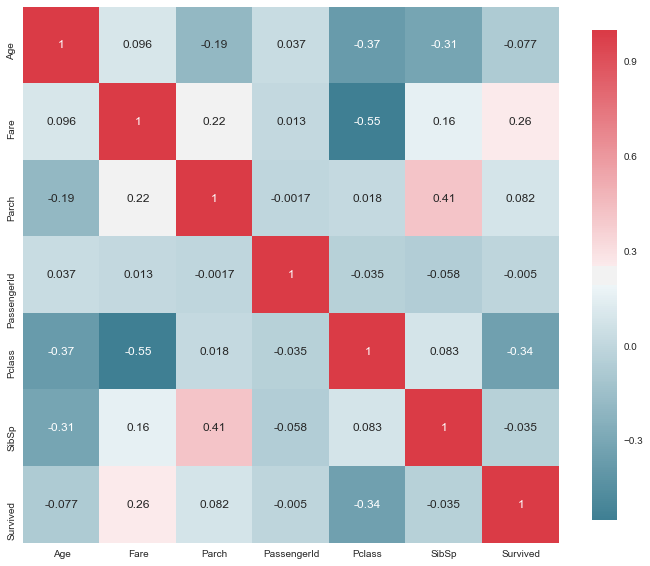

In [113]:
plot_correlation_map(X_train)

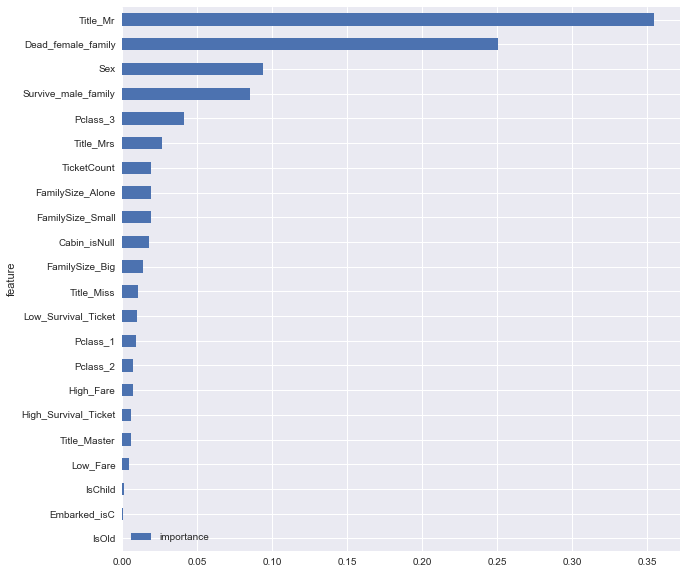

In [108]:
features = full_X.columns
le = LabelEncoder()
for feature in features:
    le = le.fit(full_X[feature])
    full_X[feature] = le.transform(full_X[feature])
feature_importance = pd.DataFrame()
feature_importance['feature'] = features
feature_importance['importance'] = model.feature_importances_
feature_importance.sort_values(by='importance', ascending=True, inplace=True)
feature_importance.set_index('feature', inplace=True)
feature_importance.plot(kind='barh', figsize=(10, 10))

In [111]:
logreg = LogisticRegression()
score = 0
for i in range(0,100):
    num_test = 0.20
    X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_train, y_train, test_size=num_test)
    logreg.fit(X_tr, Y_tr)
    acc_log = round(logreg.score(X_cv, Y_cv) * 100, 2)
    score+=acc_log
score/100

coeff_df = pd.DataFrame()
coeff_df['Feature'] = features
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])
coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
7,Dead_female_family,3.766882
1,Title_Master,1.077347
5,IsChild,1.004772
4,Title_Mrs,0.998335
20,High_Fare,0.630770
9,FamilySize_Alone,0.614658
11,FamilySize_Small,0.478224
12,High_Survival_Ticket,0.406637
18,Pclass_3,0.326848
14,Embarked_isC,0.075664


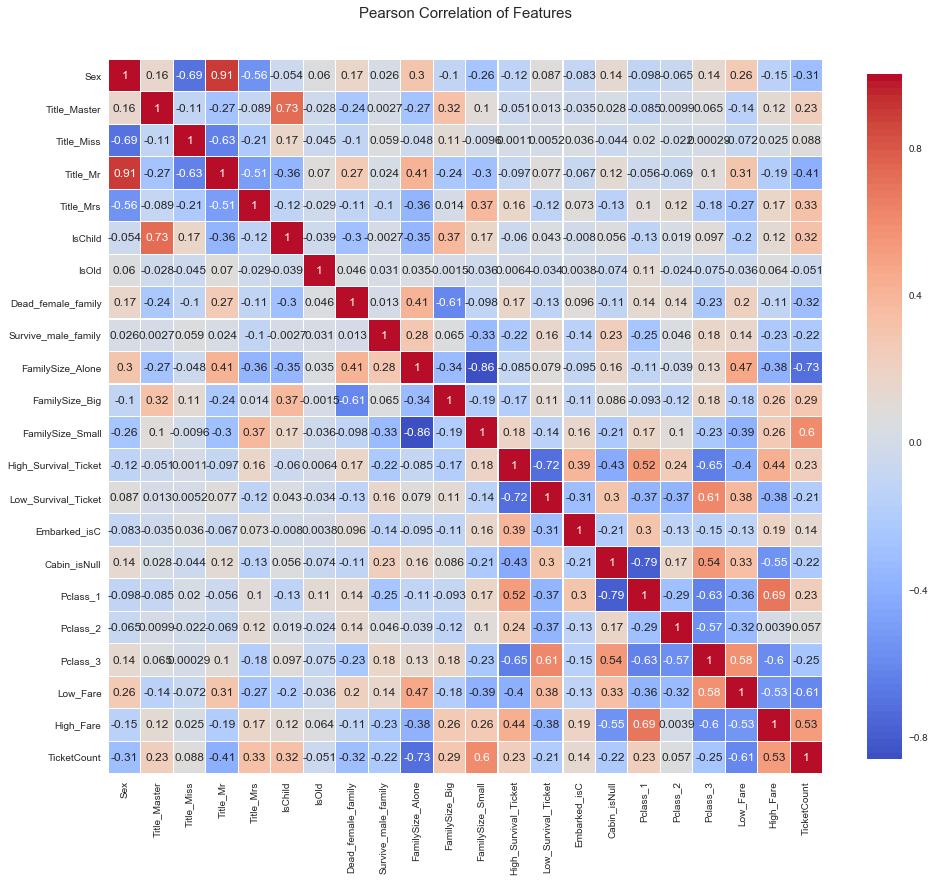

In [127]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(16, 14))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    colormap = sns.color_palette("coolwarm", 100)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(X_train)